In [216]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [217]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [3]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'fra.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [221]:
output_sentences_inputs[0]

'<sos> Va !'

In [222]:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

Wake up.
Réveille-toi ! <eos>
<sos> Réveille-toi !


In [223]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

print(word2idx_inputs['wake'], word2idx_inputs['up'])
print(input_integer_seq[172])

Total unique words in the input: 3486
Length of longest sentence in input: 6
353 37
[353, 37]


In [227]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

#print(output_tokenizer.word_index)
#print(output_integer_seq)

Total unique words in the output: 9576
Length of longest sentence in the output: 13


In [230]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (20000, 6)
encoder_input_sequences[172]: [  0   0   0   0 353  37]


In [231]:
print(word2idx_inputs["wake"])
print(word2idx_inputs["up"])

353
37


In [232]:
decoder_output_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_input_sequences[172]:", decoder_output_sequences[172])

decoder_output_sequences.shape: (20000, 13)
decoder_input_sequences[172]: [   2 2798    5    0    0    0    0    0    0    0    0    0    0]


In [233]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["réveille-toi"])
print(word2idx_outputs["!"])

2
2798
5


### Word Embedding

In [234]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [235]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
print("Number of words: ",num_words)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
print("Embedding Matrix: ",len(embedding_matrix))

for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Number of words:  3487
Embedding Matrix:  3487


In [13]:
#both are same
print(embeddings_dictionary['wake'])
print(embedding_matrix[353])

[-8.1851e-02 -1.9045e-01  1.5264e-01 -4.3457e-01 -4.7260e-01  1.7407e-01
 -2.6074e-01  5.2102e-02 -2.8279e-01 -2.3450e-01  5.7883e-02  9.2009e-02
 -1.0311e-02  4.8314e-01 -1.7252e-01  2.8857e-01 -7.6052e-01  8.9630e-02
 -6.7830e-01  3.5658e-01  1.2491e-01 -1.3805e-01 -1.5770e-02  9.7853e-02
 -8.0533e-02  2.3848e-01 -4.0822e-01  1.6076e-01  4.9103e-01  2.8170e-01
  2.6816e-01 -5.7506e-02  2.1453e-01  1.5525e-02 -9.6215e-01 -3.0120e-01
  2.0162e-01 -2.3191e-01  2.8607e-01 -4.1694e-01 -9.1846e-01 -4.0473e-01
  1.3875e-01 -1.8657e-01  3.4090e-01  4.3070e-01  6.9979e-01  4.9601e-01
  3.6675e-01 -1.4013e+00  2.4210e-02  1.6995e-01  7.5211e-02  2.1496e-01
  9.7932e-02 -2.1453e+00  5.4272e-01  4.3674e-02  1.2825e+00 -4.0673e-02
 -5.6434e-01  6.1083e-01 -3.2741e-01 -6.8980e-01  3.5443e-02  2.4135e-01
 -2.8724e-01  9.3190e-02  1.6530e-01  1.7580e-01 -1.4501e-01  1.2011e-03
 -7.6437e-01  1.0893e-01 -4.9510e-01  3.4844e-01  2.6701e-03  2.9567e-01
 -6.6956e-01  2.4645e-01  6.9674e-01 -9.4260e-02 -2

In [236]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

### Creating the Model

In [15]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [16]:
decoder_targets_one_hot.shape

(20000, 13, 9577)

In [17]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [26]:
#print(decoder_output_sequences)
print(decoder_targets_one_hot)

[[[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


In [180]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))

x = embedding_layer(encoder_inputs_placeholder)

encoder = LSTM(LSTM_NODES, return_state = True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [181]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state = encoder_states)

In [182]:
decoder_dense = Dense(num_words_output, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [183]:
model = Model(inputs = [encoder_inputs_placeholder, decoder_inputs_placeholder], outputs = decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

### Plot the Model

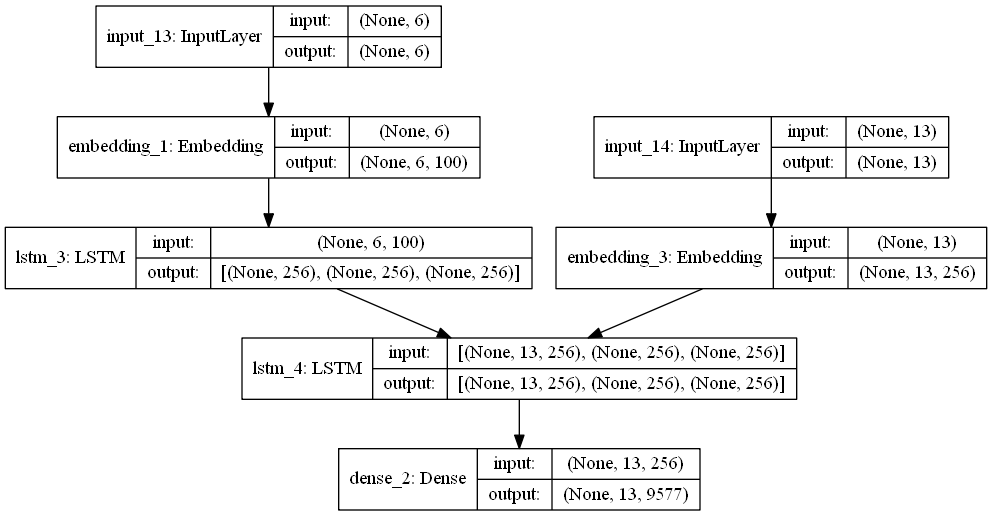

In [184]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [185]:
from keras.callbacks import EarlyStopping 
EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

r = model.fit(
    [encoder_input_sequences, decoder_output_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.25
)

Train on 15000 samples, validate on 5000 samples
Epoch 1/20
15000/15000 [==============================] - 350s 23ms/step - loss: 1.9171 - accuracy: 0.7416 - val_loss: 1.6285 - val_accuracy: 0.7566
Epoch 2/20
15000/15000 [==============================] - 411s 27ms/step - loss: 1.0701 - accuracy: 0.8504 - val_loss: 1.1705 - val_accuracy: 0.8450
Epoch 3/20
15000/15000 [==============================] - 444s 30ms/step - loss: 0.8147 - accuracy: 0.8905 - val_loss: 1.0082 - val_accuracy: 0.8759
Epoch 4/20
15000/15000 [==============================] - 457s 30ms/step - loss: 0.6887 - accuracy: 0.9090 - val_loss: 0.9211 - val_accuracy: 0.8904
Epoch 5/20
15000/15000 [==============================] - 433s 29ms/step - loss: 0.5990 - accuracy: 0.9209 - val_loss: 0.8557 - val_accuracy: 0.9001
Epoch 6/20
15000/15000 [==============================] - 383s 26ms/step - loss: 0.5349 - accuracy: 0.9302 - val_loss: 0.8180 - val_accuracy: 0.9084
Epoch 7/20
15000/15000 [==============================] -

KeyboardInterrupt: 

In [186]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(model, 'eng_fre.pkl') 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['eng_fre.pkl']

In [187]:
md = joblib.load('eng_fre.pkl')

In [188]:
md.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 6, 100)       348700      input_13[0][0]                   
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 13, 256)      2451712     input_14[0][0]                   
____________________________________________________________________________________________

In [189]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 6, 100)       348700      input_13[0][0]                   
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 13, 256)      2451712     input_14[0][0]                   
____________________________________________________________________________________________

### Model Modification for Prediction

In [204]:
#No change in Encoder model

encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [205]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]

In [206]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [207]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_input)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [208]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_input,
    [decoder_outputs] + decoder_states
)

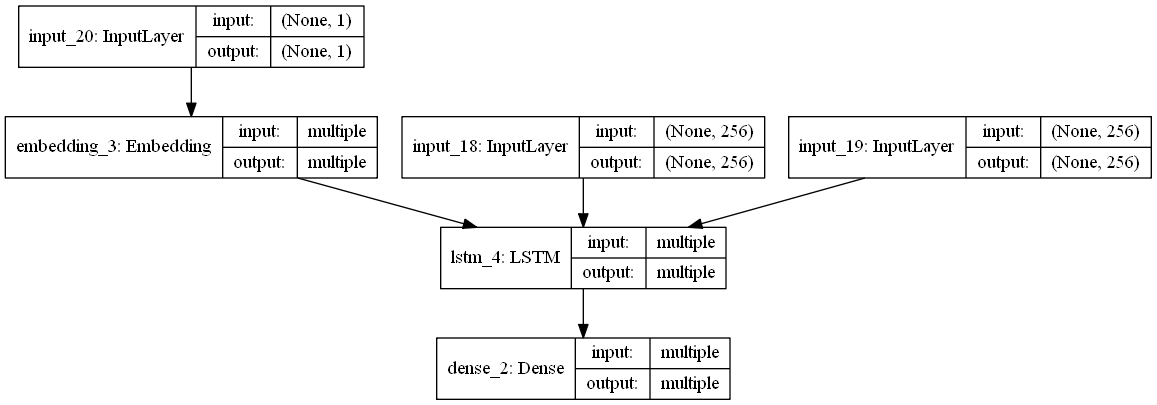

In [209]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [210]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [211]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [212]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: I'm tall.
Response: <sos> <sos> <sos> <sos> <sos> grande. grande. grande. grande. grande. grande. grande. grande.


In [215]:
print(input_sentences[i])
print(output_sentences_inputs[i])

I'm tall.
<sos> Je suis grande.


'<sos> Je suis grande.'